In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
!pip3 install statsmodels

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels 

In [7]:
from pylab import rcParams
rcParams['figure.figsize'] = 12,4

In [8]:
df = pd.read_csv("airline_passengers.csv",index_col='Month',parse_dates=True)

In [9]:
df = df.dropna()

In [10]:
df.head(2)

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118


In [11]:
df.rename(columns={'Thousands of Passengers' : 'Traffic'},inplace=True)

## Hodrick-Prescott Filter

##### Using Hodrick-Prescott Filter, we can separate the cyclical components and trend components

In [12]:
from statsmodels.tsa.filters.hp_filter import hpfilter

traffic_cyclical, traffic_trend = hpfilter(df['Traffic'],lamb=129600)

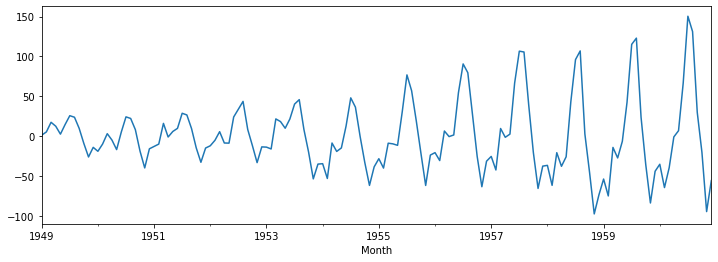

In [13]:
traffic_cyclical.plot(figsize=(12,4));

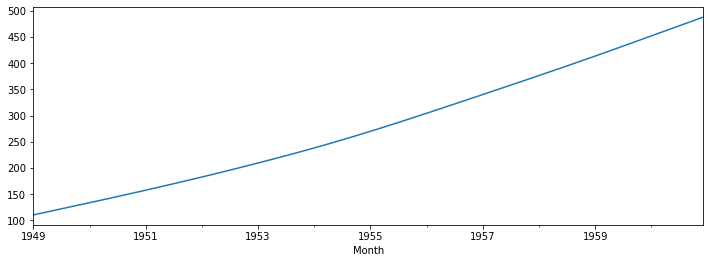

In [14]:
traffic_trend.plot(figsize=(12,4));

In [15]:
df['Trend'] = traffic_trend

In [16]:
df.head(2)

,Traffic,Trend
Month,,
1949-01-01,112,110.642382
1949-02-01,118,112.572298


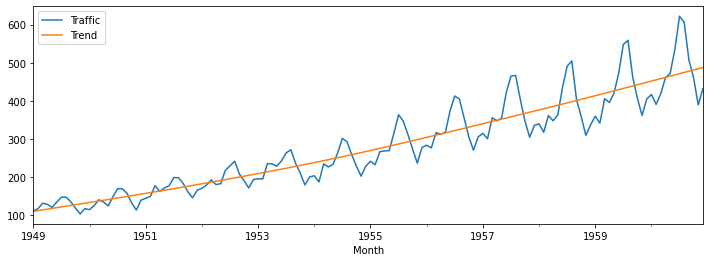

In [17]:
df[['Traffic','Trend']].plot(figsize=(12,4));

## ETS Decompose

#### Breaks down a time-series into a trend component, a seasonality component and an error(residual) component

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [19]:
results = seasonal_decompose(df['Traffic'],model='multiplicative')

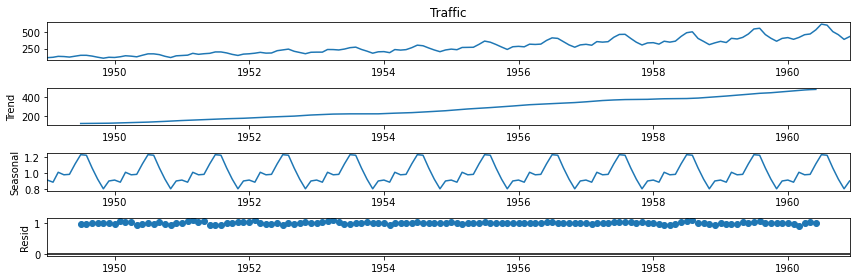

In [20]:
results.plot();

# Holt-Winters Method

#### Holt-Winters method provides a triple exponential smoothing for level, trend and seasonal components

In [21]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [22]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [23]:
df.index.freq = 'MS'

In [24]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq='MS')

In [25]:
span = 12
alpha = 2/(span+1)

In [26]:
# apply single exponential smoothing
df['Ses12'] = SimpleExpSmoothing(df['Traffic']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)

In [27]:
df.head(2)

,Traffic,Trend,Ses12
Month,,,
1949-01-01,112,110.642382,112.000000
1949-02-01,118,112.572298,112.923077


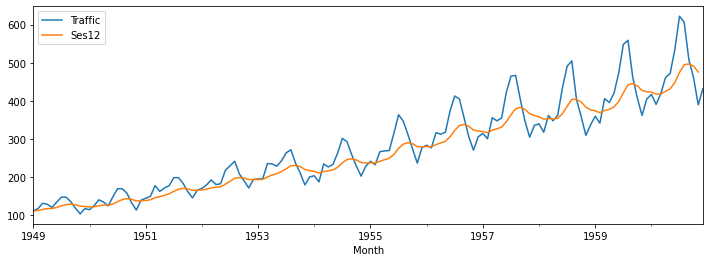

In [28]:
df[['Traffic','Ses12']].plot();

In [29]:
# apply double exponential smoothing ie Holts Method
from statsmodels.tsa.holtwinters import ExponentialSmoothing

df['Des12'] = ExponentialSmoothing(df['Traffic'],trend='add').fit().fittedvalues.shift(-1) 

In [30]:
df.head(2)

,Traffic,Trend,Ses12,Des12
Month,,,,
1949-01-01,112,110.642382,112.000000,114.726025
1949-02-01,118,112.572298,112.923077,120.710594


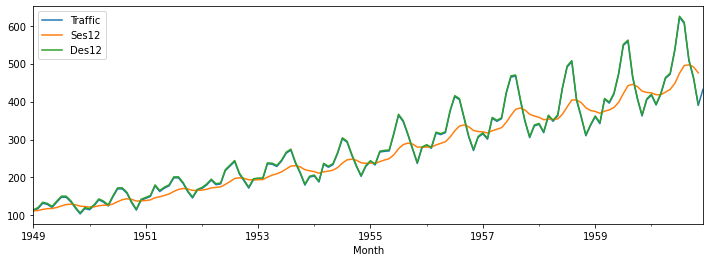

In [31]:
df[['Traffic','Ses12','Des12']].plot();

With Double Exponential Smoothing , we are able to fit the timeseries trend quite accurately as can be seen above

In [32]:
# apply triple exponential smoothing or holt-winters method, that is add seasonality factor

df['Tes12'] = ExponentialSmoothing(df['Traffic'], trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues

In [33]:
df.head(2)

,Traffic,Trend,Ses12,Des12,Tes12
Month,,,,,
1949-01-01,112,110.642382,112.000000,114.726025,112.004219
1949-02-01,118,112.572298,112.923077,120.710594,120.168118


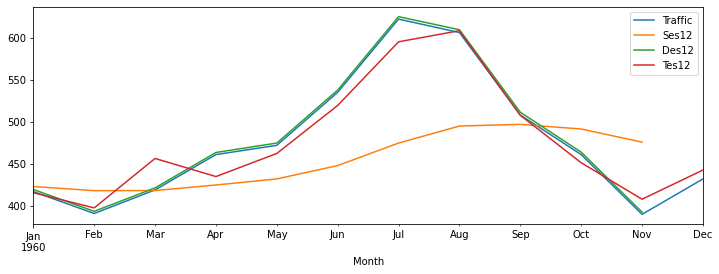

In [34]:
df[['Traffic','Ses12','Des12','Tes12']].iloc[-12:].plot();

We observe in this case that the Double exponentiation fits the data better than even Triple exponentiation.

## Plotting ACF and PACF

In [36]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

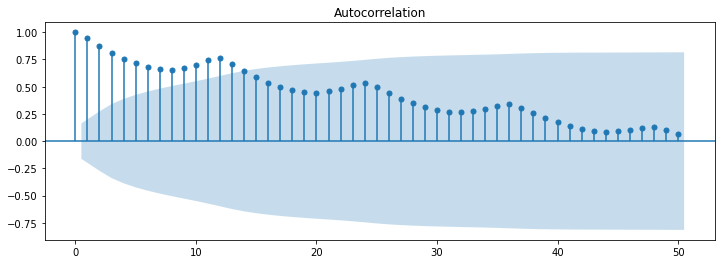

In [38]:
plot_acf(df['Traffic'],lags=50);

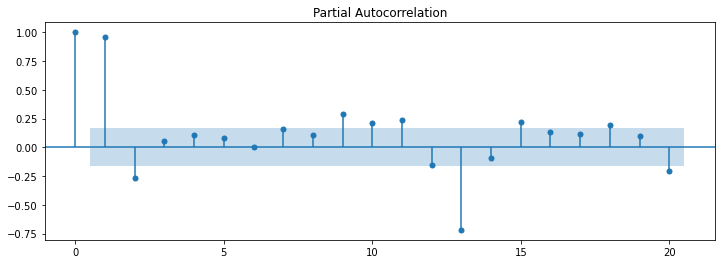

In [42]:
plot_pacf(df['Traffic'],lags=20);

## AD Fuller Test

To check the stationarity of data

In [43]:
from statsmodels.tsa.stattools import adfuller

In [44]:
adfuller(df['Traffic'])

(0.8153688792060502,
 0.991880243437641,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

In [46]:
pvalue = adfuller(df['Traffic'])[1]
pvalue

0.991880243437641

As p-value is greater than 0.05, we can conclude that there is not enough evidence to reject null hypothesis and the data is not stationary 

## Month Plots and Quarter Plots

#### These plots  give a better picture about the seasonality in data

In [47]:
from statsmodels.graphics.tsaplots import month_plot,quarter_plot

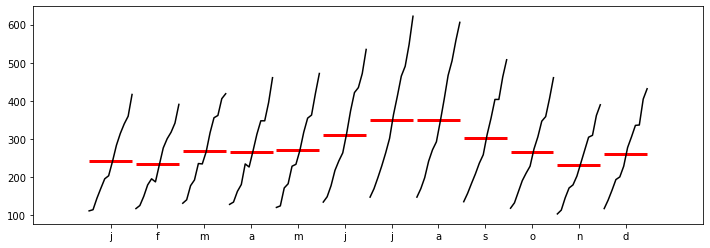

In [49]:
month_plot(df['Traffic']);

The red line represent the average for that month.We can make out that the passenger traffic increaeses in the summer months and maybe a little during december which is also a holiday month.

For plotting the quarter plot, we need to change the frequency from 'MS'(month start) to 'Q'(quarter) 

In [51]:
df_quarter = df['Traffic'].resample(rule='Q').mean()

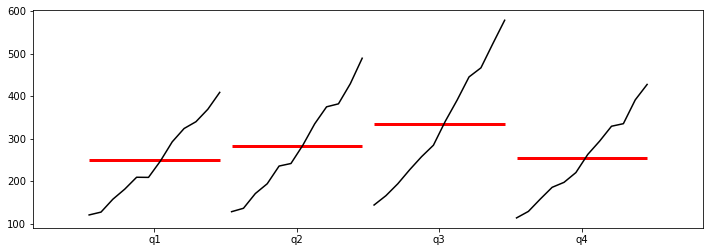

In [54]:
quarter_plot(df_quarter);

Here also we can see that the traffic is more in the 3rd quarter, which has all the summer months